# Checkpoint 4: Machine Learning

In [1]:
from python import helpers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%load_ext autoreload
%autoreload 2

## Data Preprocessing

Our goal for this checkpoint is to compare the police districts of Chicago, grouped into North, Central, West, and South regions. First, we use our pre-made CSV files to load our data into dictionaries: number of complaints per year per district, number of officers per district, civilian population per district, and ratios of Use of Force and Illegal Search allegations to all allegations. 

The complaint data used only enumerates complaints that fall into the "Use Of Force" or "Illegal Search" categories, as these are the two types of complaints that would be seen as most malicious.

In [2]:
complaint_dict = helpers.prepare_complaints()
officer_dict = helpers.prepare_officers()
population_dict = helpers.prepare_population()
uof_ratios, ill_search_ratios = helpers.prepare_ratios()

In [3]:
districts = list(complaint_dict.keys())
print(districts[0:7])

['15th', '17th', '25th', '2nd', '22nd', '18th', '16th']


In [4]:
print(uof_ratios['2nd'])

{'2005': 0.2054263565891473, '2003': 0.2087378640776699, '2018': 0.10204081632653061, '2001': 0.16042154566744732, '2016': 0.0891089108910891, '2002': 0.22366288492706646, '2009': 0.2491349480968858, '2004': 0.18911917098445596, '2007': 0.23469387755102042, '2006': 0.21951219512195122, '2017': 0.14736842105263157, '2013': 0.10572687224669604, '2014': 0.08839779005524862, '2008': 0.2724458204334365, '2012': 0.19021739130434784, '2015': 0.06179775280898876, '2011': 0.1595744680851064, '2010': 0.2737226277372263}


Now, we spend the next few cells grouping districts into regional buckets. These 'buckets' were hand-picked by observing a map of Chicago, and each region represents 5-6 districts. We perform this grouping operation for each of the statistics obtained above.

In [5]:
north   = ['16th', '17th', '24th', '20th', '19th']
central = ['14th', '18th', '12th',  '1st',  '9th', '2nd']
west    = ['25th', '15th', '11th', '10th',  '8th']
south   = [ '7th',  '3rd',  '6th',  '4th', '22nd', '5th']

### Complaints

First, we combine the per-district complaint data to create per-area complaint data. This is done by iterating through the complete dictionary, choosing only those districts that are relevant to the region, then using a Python Counter to merge the sub-dictionaries.

In [6]:
north_complaints = helpers.merge_dicts(north, complaint_dict)
central_complaints = helpers.merge_dicts(central, complaint_dict)
west_complaints = helpers.merge_dicts(west, complaint_dict)
south_complaints = helpers.merge_dicts(south, complaint_dict)

In [7]:
print("The complaints for the northern region per year are as follows:\n")
print(north_complaints)

The complaints for the northern region per year are as follows:

Counter({'2007': 14534, '2008': 14418, '2009': 14393, '2001': 13620, '2010': 12603, '2002': 12376, '2011': 12282, '2003': 11277, '2012': 10983, '2013': 10829, '2006': 10268, '2005': 9861, '2004': 9638, '2014': 7962, '2015': 7703, '2016': 7331, '2017': 6491, '2018': 3005})


### Police Officers

Because this data is also a raw number, similar to complaint data, we can merely take the sum of the data for all included police districts. 

In [8]:
north_cops = helpers.merge_dicts(north, officer_dict)
central_cops = helpers.merge_dicts(central, officer_dict)
west_cops = helpers.merge_dicts(west, officer_dict)
south_cops = helpers.merge_dicts(south, officer_dict)

In [9]:
print(f'Number of officers active in the northern region: {north_cops}\n')

Number of officers active in the northern region: Counter({'2001': 897, '2002': 852, '2003': 802, '2007': 712, '2008': 697, '2006': 609, '2004': 605, '2005': 567, '2009': 553, '2010': 486, '2011': 464, '2012': 374, '2013': 364, '2015': 362, '2014': 358, '2016': 242, '2017': 221, '2018': 56})



### Population

As we did not have historic (yearly) data for civilian population, we instead opted to use the static data available to us through the CPDP dataset. As such, this is a count of the number of civilians per district, and we can sum the values without the need for a Counter to help with the process.

In [10]:
north_pop = helpers.merge_values(north, population_dict)
central_pop = helpers.merge_values(central, population_dict)
west_pop = helpers.merge_values(west, population_dict)
south_pop = helpers.merge_values(south, population_dict)

In [11]:
print(f'Number of civilians in the northern region: {north_pop}')

Number of civilians in the northern region: 776681


### Allegation Proportions

Because this data is proportional, instead of being able to merge the dictionaries via summation, we must average the final sums by the number of districts grouped, instead. We also take this opportunity to round the data for both allegation proportions to four decimal places, to facilitate human understanding.

Below, 'uof' refers to the data collected for 'Use of Force' allegations, while 'ils' refers to the data for 'Illegal Search' allegations.

In [12]:
north_uof = helpers.avg_dicts(north, uof_ratios)
central_uof = helpers.avg_dicts(central, uof_ratios)
west_uof = helpers.avg_dicts(west, uof_ratios)
south_uof = helpers.avg_dicts(south, uof_ratios)

In [13]:
print(north_uof)

{'2015': 0.2042, '2018': 0.1439, '2005': 0.2328, '2013': 0.2105, '2003': 0.1951, '2016': 0.1423, '2008': 0.193, '2009': 0.1979, '2012': 0.1957, '2006': 0.2463, '2010': 0.2353, '2004': 0.1718, '2001': 0.1977, '2011': 0.2316, '2007': 0.2142, '2014': 0.1465, '2002': 0.2027, '2017': 0.1136}


In [14]:
north_ils = helpers.avg_dicts(north, ill_search_ratios)
central_ils = helpers.avg_dicts(central, ill_search_ratios)
west_ils = helpers.avg_dicts(west, ill_search_ratios)
south_ils = helpers.avg_dicts(south, ill_search_ratios)

## Linear Regression

Now that we've grouped our data, we can begin building a regression model for each of the regions. We can compare the obtained model for each region by looking at it's coefficients and intercept.

### North

In [15]:
X, y = helpers.format_data(north_complaints, north_pop, north_cops, north_uof, north_ils)

reg = LinearRegression().fit(X, y)

Coefficients: (-0.0005684, -0.0000048)
Intercept: 1.158
R^2: 0.528


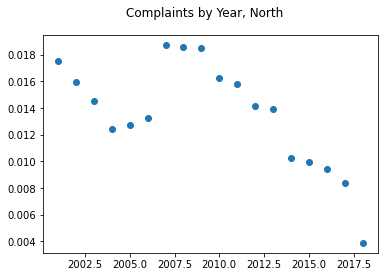

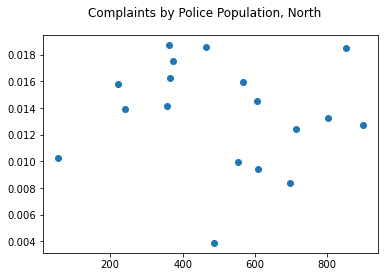

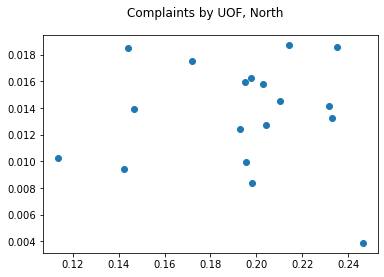

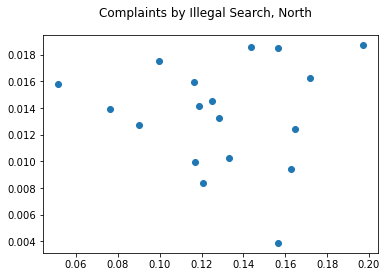

In [16]:
print('Coefficients: (%.7f, %.7f)' % (reg.coef_[0], reg.coef_[1]))
print('Intercept: %.3f' % reg.intercept_)
print('R^2: %.3f' % reg.score(X, y))

for n, title in enumerate(['Complaints by Year, North', 'Complaints by Police Population, North', 'Complaints by UOF, North', 'Complaints by Illegal Search, North']):
    plt.scatter([x[n] for x in X], y)
    plt.suptitle(title)
    plt.show()

### Central

In [17]:
X, y = helpers.format_data(central_complaints, central_pop, central_cops, central_uof, central_ils)

reg = LinearRegression().fit(X, y)

Coefficients: (-0.0014040, -0.0000037)
Intercept: 2.858
R^2: 0.786


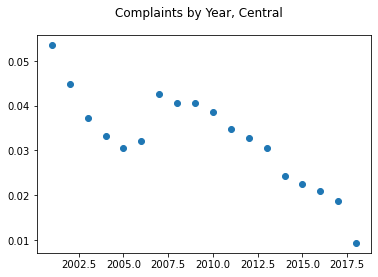

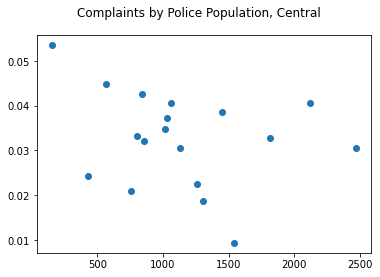

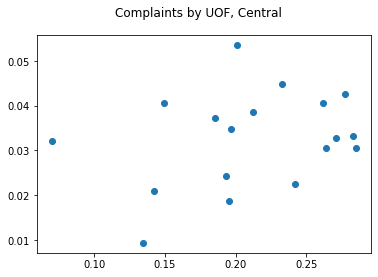

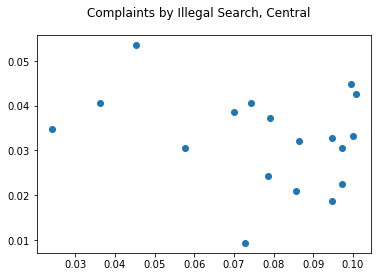

In [18]:
print('Coefficients: (%.7f, %.7f)' % (reg.coef_[0], reg.coef_[1]))
print('Intercept: %.3f' % reg.intercept_)
print('R^2: %.3f' % reg.score(X, y))

for n, title in enumerate(['Complaints by Year, Central', 'Complaints by Police Population, Central', 'Complaints by UOF, Central', 'Complaints by Illegal Search, Central']):
    plt.scatter([x[n] for x in X], y)
    plt.suptitle(title)
    plt.show()

### West

In [19]:
X, y = helpers.format_data(west_complaints, west_pop, west_cops, west_uof, west_ils)

reg = LinearRegression().fit(X, y)

Coefficients: (-0.0008364, 0.0000044)
Intercept: 1.706
R^2: 0.488


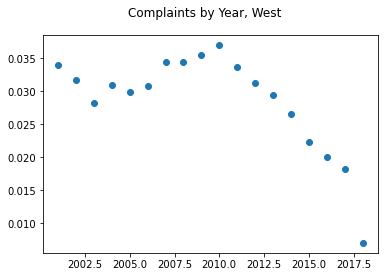

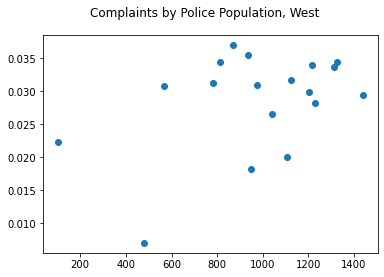

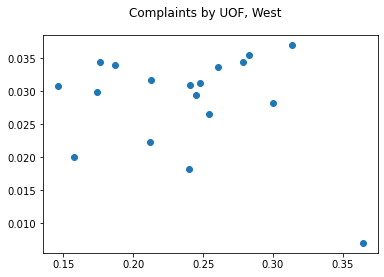

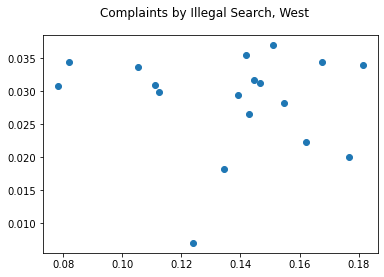

In [20]:
print('Coefficients: (%.7f, %.7f)' % (reg.coef_[0], reg.coef_[1]))
print('Intercept: %.3f' % reg.intercept_)
print('R^2: %.3f' % reg.score(X, y))

for n, title in enumerate(['Complaints by Year, West', 'Complaints by Police Population, West', 'Complaints by UOF, West', 'Complaints by Illegal Search, West']):
    plt.scatter([x[n] for x in X], y)
    plt.suptitle(title)
    plt.show()

### South

In [21]:
X, y = helpers.format_data(south_complaints, south_pop, south_cops, south_uof, south_ils)

reg = LinearRegression().fit(X, y)

Coefficients: (-0.0011854, 0.0000042)
Intercept: 2.431
R^2: 0.264


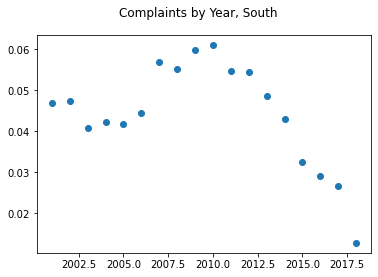

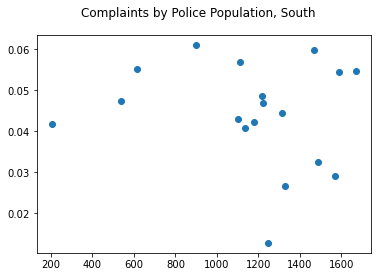

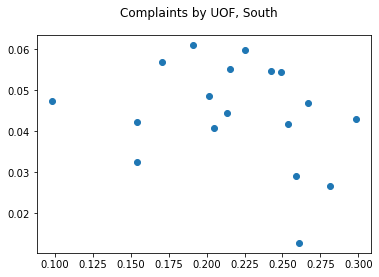

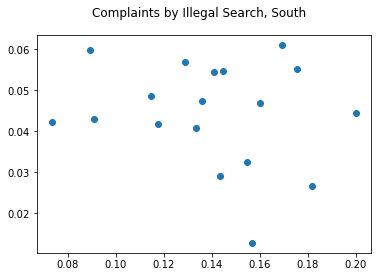

In [22]:
print('Coefficients: (%.7f, %.7f)' % (reg.coef_[0], reg.coef_[1]))
print('Intercept: %.3f' % reg.intercept_)
print('R^2: %.3f' % reg.score(X, y))

for n, title in enumerate(['Complaints by Year, South', 'Complaints by Police Population, South', 'Complaints by UOF, South', 'Complaints by Illegal Search, South']):
    plt.scatter([x[n] for x in X], y)
    plt.suptitle(title)
    plt.show()